In [1]:
import numpy as np
import pickle
import numpy.matlib
import matplotlib.pyplot as plt
import sys

In [12]:
###############################################################

# Matlab -> Python functions

###############################################################

# Loades an entire batch
def LoadBatch(filename):
	""" Copied from the dataset website """ 
	with open('Datasets/'+filename, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes') 
	return dict

# Calculate softmax for class class estimation of each image (vector)
def softmax(x):
	""" Standard definition of the softmax function """
	exp_x = np.exp(x)
	return exp_x / np.sum(exp_x, axis=0)

def StableSoftmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax
def ComputeGradsNumSlow(X, Y, W, b, lamba, k, h, beta=None, gamma=None, mean=None, var=None, batch_norm=False):
    """
    Compute gradients numerically via the centred difference method
    :param X: numpy array of shape dxN, batch of N input images
    :param Y: numpy array of shape KxN, batch of N one-hot image labels
    :param W: list of nxm numpy arrays, containing (in order) the weights of the first layer, then the second, etc.
    :param b: list of nx1 numpy arrays, containing (in order) the biases of the first layer, then the second, etc.
    :param lamba: float, lambda parameter for loss function
    :param h: float, step size for numerical analysis
    :return: list of numpy arrays grad_W, grad_b, of same format as W and b, respectively
    """
    grad_W = [np.zeros(w_n.shape) for w_n in W]
    grad_b = [np.zeros(b_n.shape) for b_n in b]
    
    if(batch_norm):
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
        c = ComputeCost(X, Y, W, b, lambd, k, gamma, beta, mean, var, batch_norm)


    for j in range(len(grad_b)):
        bj_size = grad_b[j].shape[0]  #
        for i in range(bj_size):
            b_try = [bj.copy() for bj in b]
            b_try[j][i] -= h
            c1 = ComputeCost(X, Y, W, b_try, lambd, k)

            b_try = [bj.copy() for bj in b]
            b_try[j][i] += h
            c2 = ComputeCost(X, Y, W, b_try, lambd, k)

            grad_b[j][i] = (c2 - c1) / (2*h)

    for j in range(len(grad_W)):
        Wj = grad_W[j]
        for i in range(Wj.shape[0]):
            for k in range(Wj.shape[1]):
                W_try = [wj.copy() for wj in W]
                W_try[j][i,k] -= h
                c1 = ComputeCost(X, Y, W_try, b, lambd, k)

                W_try = [wj.copy() for wj in W]
                W_try[j][i,k] += h
                c2 = ComputeCost(X, Y, W_try, b, lambd, k)
                grad_W[j][i,k] = (c2 - c1) / (2*h)
                
            if j<(k-1) and batch_norm:
                # Gradients for gamma
                for i in range(gamma[j].shape[0]):
                    gamma_try = [gamma_l.copy() for gamma_l in gamma]
                    gamma_try[j][i,0] += h
                    c2 = ComputeCost(X, Y, W, b, lambd, k, gamma_try, beta, mean, var, batch_norm)
                    grad_gamma[j][i,0] = (c2-c)/h

                # Gradients for betas
                for i in range(beta[j].shape[0]):
                    beta_try = [beta_l.copy() for beta_l in beta]
                    beta_try[j][i,0] += h
                    c2 = ComputeCost(X, Y, W, b, lambd, k, gamma, beta_try, mean, var, batch_norm)
                    grad_beta[j][i,0] = (c2-c)/h
    
    if batch_norm:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

    return grad_W, grad_b


# Allows for efficiently view the images in a directory or 
# in a *Matlab* array or cell array
def montage(W):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(2,5)
	for i in range(2):
		for j in range(5):
			im  = W[i*5+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(5*i+j))
			ax[i][j].axis('off')
	plt.show()



In [16]:
###############################################################

# My functions

###############################################################

# Read pixel data, labels (classes), one-hot rep. of labels (classes)
# Divide pixel data by 255 for correct format
def ReadData(filename):
    data_batch = LoadBatch(filename)
    pixel_data = data_batch[b'data'].T
    labels = data_batch[b'labels']
    one_hot = np.eye(10)[labels].T
    return pixel_data, one_hot, labels 

# Normalize w.r.t. training data mean and standard deviation
# Normalization of input so that the inputs are at a comparable range
def Normalize(train, validation,test=None):
        train=np.float64(train)
        validation=np.float64(validation)
        
        mean_X =train.mean(axis=1)

        std_X=train.std(axis=1)

        train=train-mean_X[:,None]

        train=train/std_X[:,None]
        validation=validation-mean_X[:,None]
        validation=validation/std_X[:,None]
        
        if(test is not None):
            test=np.float64(test)
            test=test-mean_X[:,None]
            test=test/std_X[:,None]
            return train,validation,test;
        
        return train,validation;

# First init of model params W(eights) and b(ias)
# Init done with 0 mean and 1 / sqrt of d and m
# Random seed for selecting the same rndm numbers for each execution
def GetWeightAndBias(X, Y, k, hidden_dimension, batch_norm=False):
    
    W=[None]*(k+1)
    print(W)
    b=[None]*(k+1)
    beta=[None]*k
    gamma=[None]*k

    # Image pixles (input öayer)
    d=X.shape[0]
    # Num of classes (output layer)
    K = 10
    
    for i in range(k):
        
        # Changes dimensions for each iteration
        m=hidden_dimension[i]

        # He initialization for weights
        W[i] = np.random.normal(size=(m, d), loc=0, scale=(np.sqrt(2/d)))
        b[i] = np.zeros(shape=(m,1))
        
        if(batch_norm):
            beta[i] = np.zeros(shape=(m,1))
            gamma[i] = np.ones(shape=(m,1))
            
        # Update d
        d = m
    
    # Final output layer
    W[k] = np.random.normal(size=(K, d), loc=0, scale=(np.sqrt(2/d)))
    b[k] = np.zeros(shape=(K,1))
    
    if(batch_norm):
        return W, b, beta, gamma
    
    return W, b

# This is an second attemt for weight init since the former didn't work for 9 layers.
def GetWeightAndBiasProper(X, k, hidden_dimension, batch_norm=False):
    
    input_dimension = 3072
   # print(input_dimension)
    output_dimension = 10
    k = len(hidden_dimension)+1
    W, b, gamma, beta = [None]*k, [None]*k, [None]*(k-1), [None]*(k-1)
    n_nodes = [input_dimension]+hidden_dimension+[output_dimension]
    
    np.random.seed(400)
    for l in range(k):
        inputs = n_nodes[l]
        outputs = n_nodes[l+1]
        
        # He init
        scale = np.sqrt(2/inputs) 
        
        W[l] = np.random.normal(size=(outputs, inputs), loc=0, scale=scale)
        b[l] = np.zeros((outputs, 1))
        if l<(k-1):
            gamma[l] = np.ones((outputs, 1))
            beta[l] = np.zeros((outputs, 1))
        
    return W, b, gamma, beta

# Weight init for sigma experiments
def GetWeightsAndBiasSigma(X,input_dimension,hidden_dimension,output_dimension,k,batch_norm=False,std=0.01):
    W=[None]*(k+1)
    b=[None]*(k+1)
    if(batch_norm):
        beta = [None]*k
        gamma = [None]*k
    d = input_dimension
    
    # Essentially the same as former one 
    # but we keep inputting new standard deviation values (see next function)
    for i in range(k):
        m=hidden_dimension[i]
        W[i] = np.random.normal(size=(m, d), loc=0, scale=std)
        b[i] = np.zeros(shape=(m,1))
        if(batch_norm):
            beta[i] = np.zeros(shape=(m,1))
            gamma[i] = np.ones(shape=(m,1))
        d = m
        
    W[k] = np.random.normal(size=(output_dimension, d), loc=0, scale=std)
    b[k] = np.zeros(shape=(output_dimension,1))
 
    if(batch_norm):
        return W,b,beta, gamma
    else:
        return W,b

# Inputs every specified sigmas in the for loop to check weight initializaiton sensitivity. 
def SigmaExperiments(X, Y, y, hidden_dimension, GDparams, X_val,
                Y_val, y_val,X_test,Y_test,y_test):
    
    for sigma in [1e-1,1e-3,1e-4]:
        W, b, gamma, beta=GetWeightsAndBiasSigma(X,input_dimension=X.shape[0],hidden_dimension=[50,50],output_dimension=Y.shape[0],k = 2,batch_norm=True,std=sigma)
        P, S_batch_Norm, S, H, mean_inp, var_inp = EvaluateClassifier(X_new_norm, W, b, 2, gamma, beta, batch_norm=True)
        W_upd, b_upd, metrics, gamma_upd, beta_upd, mean_final, var_final = MiniBatchGD2_BN(X, Y, y, GDparams, W, b, 2, 0.005, beta, gamma, mean_inp, var_inp, True, 0.9, X_val,Y_val,y_val)
        acc = ComputeAccuracy(X_test, y_test,  W_upd, b_upd, 2, gamma_upd, beta_upd, batch_norm=True)
        print('Sigma: '+str(sigma)+ ', accuracy: '+ str(acc) + '. With batch norm.')


        W, b = GetWeightsAndBiasSigma(X,input_dimension=X.shape[0],hidden_dimension=[50,50],output_dimension=Y.shape[0],k = 2,batch_norm=False,std=sigma)
        W_upd, b_upd, metrics= MiniBatchGD2(X, Y, y, GDparams, W_upd, b_upd, 2, 0.005, X_val,Y_val,y_val)
        acc = ComputeAccuracy(X_test, y_test,  W_upd, b_upd, 2, batch_norm=False)
        print('Sigma: '+str(sigma)+ ', accuracy: '+ str(acc) + '. Without batch norm.')
        print('-'*20)

# Evaluation of the network function
# Agan, Softmax returns each probability for each class label
def EvaluateClassifier(X, W, b, k, gamma=None, beta=None, mean=None, var=None, batch_norm=False):

    # Initialize different lists to correct dimensions
    k = len(b)-1
    S = [None]*(k)
    H = [X.copy()]+[None]*(k)
    S_batch_Norm = [None]*k
    S_scaled = [None]*k
    
    if(batch_norm):
        mean=[None]*k
        var=[None]*k
        
    for l in range(k):
        # Probas
        S[l]=np.dot(W[l],H[l])+b[l]
        
        # Batch norm will include gammas and betas
        if(batch_norm):
            mean[l]=S[l].mean(axis=1).reshape(-1,1)
            var[l]=S[l].var(axis=1).reshape(-1,1)
            S_batch_Norm[l]=(S[l]-mean[l])/(np.sqrt(var[l]+1e-15))
            S_scaled[l] = S_batch_Norm[l]* gamma[l]+beta[l]
            H[l+1]=np.maximum(0, S_scaled[l])
        # Else not
        else:
            H[l+1]=np.maximum(0,S[l])
            
    # Make prediction
    P=softmax(np.dot(W[k],H[k])+b[k])
    
    if(batch_norm):
        return P, S_batch_Norm, S, H[1:], mean, var

    return P,H[1:]

# Total cost of a set of images:
# 1. Regularization term, calculate: lambda * sum(W^2 ij)
# 2. Sum it with l_cross + regularization term -> for each x,y in D
# 3. Multiply everything with 1 / length of D
def ComputeCost(X, Y, W, b, lambd, k, gamma=None, beta=None, mean=None, var=None, batch_norm=False):
    
    if(batch_norm):
        P, S_batch_Norm, S, H, mean, var = EvaluateClassifier(X, W, b, k, gamma, beta, batch_norm=True)
    else:
        P, H = EvaluateClassifier(X, W, b, k)
    
    sqrt_W = 0 
    for i in range(len(W)):
        sqrt_W += (W[i]**2).sum()
        
    P = P**10e-15
    lcr = -np.sum(np.multiply(Y, np.log(P)))
    Reg_term = lambd*sqrt_W
    J = lcr/X.shape[1]+Reg_term
    
    return J


# Accuracy of the network's predictions
# Percentage of examples for which it gets the correct answer
def ComputeAccuracy(X, y, W, b, k, gamma=None, beta=None, mean=None, var=None, batch_norm=False):
    
    if(batch_norm):
        P, S_batch_Norm, S, H, mean, var = EvaluateClassifier(X, W, b, k, gamma, beta, batch_norm=True)
    else: 
        P, H = EvaluateClassifier(X, W, b, k)

    acc = np.mean(y == np.argmax(P, axis=0))
    
    return acc

# Back propagation if batch normalization is set to True
def BatchNormBackPass(G, S, mean, var):
    
    n = S.shape[1]
    sigma1 = ((var+1e-15)**(-0.5))
    sigma2 = ((var+1e-15)**(-1.5))
    G1 = G*(sigma1@(np.ones((1,n))))
    G2 = G*(sigma2@(np.ones((1,n))))
    D = S-(mean@np.ones((1,n)))
    c = (G2*D)@np.ones((n,1))
    G = (G1-1/n*(G1@np.ones((n,1))))*np.ones((1,n))-(1/n*(D*(c@np.ones((1,n)))))
    return G
    
# Compute gradients of the cost function to see the curve of cost decrease 
# Forward pass is already done since we have already calculated P
def ComputeGradients(H, X, Y, P, W, b, lambd, k, gamma=None, beta=None, mean=None, var=None, S_batch_Norm=None,S=None,batch_norm=False):
    
    # Init of lists
    k = len(b)-1
    grad_W = [None]*(k+1)
    grad_b = [None]*(k+1)
    grad_gamma = [None]*(k)
    grad_beta = [None]*k
    
    n = X.shape[1]
    H = [X.copy()]+H
    G = -(Y-P)
    
    grad_W[k] = np.dot(G,H[k].T)/n +2*lambd*W[k]
    grad_b[k] = (np.dot(G,np.ones(shape=(n,1)))/n)
    
    G = np.dot(W[k].T,G)
    G = G*(H[k]>0)
    
    for l in range(k-1,-1,-1):
        if(batch_norm):
            grad_beta[l] = 1/n*(G@np.ones((n,1)))
            grad_gamma[l] = 1/n*((G*S_batch_Norm[l])@np.ones((n,1)))
            
            G = G*(gamma[l]@np.ones((1,n)))
            G = BatchNormBackPass(G,S[l],mean[l],var[l])
            
        grad_W[l] = np.dot(G,H[l].T)/n+2*lambd*W[l]
        grad_b[l] = (np.dot(G,np.ones(shape=(n,1)))/n)
        G = np.dot(W[l].T,G)
        G = G*(H[l]>0)
        
    if(batch_norm):
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

def ComputeGradsNum_BN(X, Y, lambd, W, b, gamma, beta, mean, var, batch_norm, h=0.000001):
    
    # Create lists for saving the gradients by layers
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if batch_norm:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
    
    # Compute initial cost and iterate layers k
    k = len(W)
    c = ComputeCost(X, Y, W, b, lambd, k, gamma, beta, mean, var, batch_norm)

    print(type(c), "c")
    for l in range(k):
        
        # Gradients for bias
        for i in range(b[l].shape[0]):
            b_try = [b_l.copy() for b_l in b]
            b_try[l][i,0] += h
            c2 = ComputeCost(X, Y, W, b_try, lambd, k, gamma, beta, mean, var, batch_norm)
            grad_b[l][i,0] = (c2-c)/h
        
        # Gradients for weights
        for i in range(W[l].shape[0]):
            for j in range(W[l].shape[1]):
                W_try = [W_l.copy() for W_l in W]
                W_try[l][i,j] += h
                c2 = ComputeCost(X, Y, W_try, b, lambd, k, gamma, beta, mean, var, batch_norm)
                grad_W[l][i,j] = (c2-c)/h
                
        if l<(k-1) and batch_norm:
            
            # Gradients for gamma
            for i in range(gamma[l].shape[0]):
                gamma_try = [gamma_l.copy() for gamma_l in gamma]
                gamma_try[l][i,0] += h
                c2 = ComputeCost(X, Y, W, b, lambd, k, gamma_try, beta, mean, var, batch_norm)
                grad_gamma[l][i,0] = (c2-c)/h
            
            # Gradients for betas
            for i in range(beta[l].shape[0]):
                beta_try = [beta_l.copy() for beta_l in beta]
                beta_try[l][i,0] += h
                c2 = ComputeCost(X, Y, W, b, lambd, k, gamma, beta_try, mean, var, batch_norm)
                grad_beta[l][i,0] = (c2-c)/h
    
    if batch_norm:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

# Check if my analytical gradients 
# Using centered difference function
# If the differenc is < 1e-6, the analytical gradients are fine
def CompareGradients(X,Y, W, b, lambd, k, threshold, gamma=None, beta=None, batch_norm=False):
    
    h=0.000001
    
    # Compute gammas, betas, Ws and bs
    if(batch_norm):                               
        P, S_batch_Norm, S, H, mean, var = EvaluateClassifier(X, W, b, k, gamma, beta, mean=None, var=None, batch_norm=True)
        grad_Ws_a, grad_bs_a, grad_gamma_a, grad_beta_a = ComputeGradients(H, X, Y, P, W, b, lambd, k, gamma, beta, mean, var, S_batch_Norm, S, batch_norm=True)  
        grad_Ws_n, grad_bs_n, grad_gamma_n, grad_beta_n = ComputeGradsNum_BN(X, Y, lambd, W, b, gamma, beta, mean, var, batch_norm, h=0.000001)
        grad_gamma_abs_err = [None]*(len(grad_gamma_a))  
        grad_beta_abs_err = [None]*(len(grad_beta_a))
        grad_gamma_rel_err = [None]*(len(grad_gamma_a))
        grad_beta_rel_err = [None]*(len(grad_beta_a))
    
    # Ws and bs
    else:
        P, H = EvaluateClassifier(X, W, b, k)
        grad_Ws_a, grad_bs_a = ComputeGradients(H, X, Y,P, W, b, lambd, k)
        grad_Ws_n, grad_bs_n = ComputeGradsNumSlow(X, Y, W, b, lambd, k, h=0.00001)

    w_rel_error = list()
    b_rel_error = list()
    
    # Calculate differences
    print("Checking errors for ", k, "layers","\n")
    print("--------------------------------------------")


    for i in range(len(W)):
        w_rel_error.append(np.sum(np.abs(grad_Ws_a[i] - grad_Ws_n[i])) / np.maximum(0.00000001, np.sum(np.abs(grad_Ws_a[i]) + np.abs(grad_Ws_n[i]))))
        b_rel_error.append(np.sum(np.abs(grad_bs_a[i] - grad_bs_n[i])) / np.maximum(0.00000001, np.sum(np.abs(grad_bs_a[i]) + np.abs(grad_bs_n[i]))))

        # Check differences    
        if (w_rel_error[i] < threshold and b_rel_error[i] < threshold):
            print("Relative error for layer: ", [i+1], " is ok.")
            print("Weights relative error: ", w_rel_error[i])
            print("Bias relative error: ", b_rel_error[i], "\n")

        else:
            print("Relative error for layer: ", [i+1], " is too high.")
            print("Weights relative error: ", w_rel_error[i])
            print("Bias relative error: ", b_rel_error[i], "\n")

    print("--------------------------------------------")

    # Calculate gamma and beta differences
    if(batch_norm):
        for i in range(len(grad_gamma_a)):
            grad_gamma_abs_err[i] = np.abs(grad_gamma_n[i]-grad_gamma_a[i])
            grad_beta_abs_err[i] = np.abs(grad_beta_n[i]-grad_beta_a[i])
            print('gamma'+str(i)+str(' ')+str(np.mean(grad_gamma_abs_err[i]<1e-6)*100)+"% of absolute errors below 1e-6")
            print('beta'+str(i)+str(' ')+str(np.mean(grad_beta_abs_err[i]<1e-6)*100)+"% of absolute errors below 1e-6")
            grad_gamma_rel_err[i] = np.maximum(np.abs(grad_gamma_n[i])+np.abs(grad_gamma_a[i]), 0.00000001)
            grad_beta_rel_err[i] = np.maximum(np.abs(grad_beta_n[i])+np.abs(grad_beta_a[i]), 0.00000001)
            print('gamma'+str(i)+str(' ')+str(np.mean(grad_gamma_abs_err[i]/grad_gamma_rel_err[i]<1e-6)*100)+
              "% of relative errors below 1e-6")
            print('beta'+str(i)+str(' ')+str(np.mean(grad_beta_abs_err[i]/grad_beta_rel_err[i]<1e-6)*100)+
              "% of relative errors below 1e-6")
            

# Mini batch GD for NO BN
def MiniBatchGD2(X, Y, y, GDparams, W, b, k, lambd, X_val=None, Y_val=None, y_val=None):
    n = X.shape[1]
    (eta_min,eta_max,step_size,n_batch,cycles)=GDparams
    metrics = {'updates':[-1], 
               'Loss_scores':[ComputeCost(X, Y, W, b, lambd, k)], 
               'acc_scores':[ComputeAccuracy(X, y, W, b, k)]}
    if X_val is not None:
        metrics['Loss_val_scores'] = [ComputeCost(X_val, Y_val, W, b, lambd, k)]
        metrics['acc_val_scores'] = [ComputeAccuracy(X_val, y_val, W, b, k)]
    batches = dict()

    # N batching 
    for j in range(n//n_batch):
            j_start = (j)*n_batch
            j_end = (j+1)*n_batch
            inds = range(j_start,j_end)
            y_batch = [y[index] for index in inds]
            X_batch = X[:, inds]
            Y_batch = Y[:, inds]
            batches[j]=(X_batch,Y_batch,y_batch)
    j = 0
    
    for l in range(cycles):
        for t in range(2*l*step_size, 2*(l+1)*step_size):
            
            if t>= 2*l*step_size and t<(2*l+1)*step_size:
                eta = eta_min+(t-2*l*step_size)/step_size*(eta_max-eta_min)
            elif t>=(2*l+1)*step_size and t<2*(l+1)*step_size:
                eta = eta_max-(t-(2*l+1)*step_size)/step_size*(eta_max-eta_min)

            X_batch, Y_batch, y_batch = batches[j]
            P_batch, H_batch = EvaluateClassifier(X_batch, W, b, k)    
            grad_Ws, grad_bs = ComputeGradients(H_batch, X_batch, Y_batch, P_batch, W, b, lambd, k)

            for i in range(len(W)):
                W[i] = W[i]-eta*grad_Ws[i]
                b[i] = b[i]-eta*grad_bs[i]

            j += 1
            if j>(n//n_batch-1):
                # set j = 0 will start new epoch
                j = 0
                metrics['updates'].append(t+1)
                metrics['acc_scores'].append(ComputeAccuracy(X, y, W, b, k))
                metrics['Loss_scores'].append(ComputeCost(X, Y, W, b,lambd, k))

                if X_val is not None:
                    metrics['acc_val_scores'].append(ComputeAccuracy(X_val, y_val, W, b, k))
                    metrics['Loss_val_scores'].append(ComputeCost(X_val, Y_val, W, b, lambd, k))
                """ message = "In update "+str(t+1)+'/'+str(2*cycles*step_size)+" finishes epoch "+ \
                          str(len(metrics['updates'])-1)+": loss="+str(metrics['Loss_scores'][-1])+ \
                          " and accuracy="+str(metrics['acc_scores'][-1])+" (training set) \r"
                sys.stdout.write(message) """
                
                # Shuffling for each epoch
                rand_index=np.random.permutation(n)
                X=X[:,rand_index]
                Y=Y[:,rand_index]
                y = [y[c] for c in rand_index]
                batches=dict()
                for f in range(n//n_batch):
                    j_start = (f)*n_batch ;
                    j_end = (f+1)*n_batch;
                    inds = range(j_start,j_end);
                    y_batch = [y[index] for index in inds]
                    X_batch = X[:, inds];
                    Y_batch = Y[:, inds];
                    batches[f]=(X_batch,Y_batch,y_batch)
            
        
    
    return W, b, metrics 

# MiniBatchGD WITH BN.
def MiniBatchGD2_BN(X, Y, y, GDparams, W, b, k, lambd, beta, gamma, mean_input, var_input, batch_norm, alpha, X_val=None, Y_val=None, y_val=None):
    n = X.shape[1]
    (eta_min,eta_max,step_size,n_batch,cycles)=GDparams
    metrics = {'updates':[-1], 
               'Loss_scores':[ComputeCost(X, Y, W, b, lambd, k, gamma, beta, mean_input, var_input, batch_norm)], 
               'acc_scores':[ComputeAccuracy(X, y, W, b, k, gamma, beta, mean_input, var_input, batch_norm)]}
    if X_val is not None:
        metrics['Loss_val_scores'] = [ComputeCost(X, Y, W, b, lambd, k, gamma, beta, mean_input, var_input, batch_norm)]
        metrics['acc_val_scores'] = [ComputeAccuracy(X_val, y_val, W, b, k, gamma, beta, mean_input, var_input, batch_norm)]
    batches = dict()
    # N batching 
    for j in range(n//n_batch):
            j_start = (j)*n_batch
            j_end = (j+1)*n_batch
            inds = range(j_start,j_end)
            y_batch = [y[index] for index in inds]
            X_batch = X[:, inds]
            Y_batch = Y[:, inds]
            #gamma_batch = gamma[:, inds]
            #beta_batch = beta[:, inds]
            batches[j]=(X_batch,Y_batch,y_batch)#, gamma_batch, beta_batch)
    j = 0
    
    for l in range(cycles):
        for t in range(2*l*step_size, 2*(l+1)*step_size):
            
            if t>= 2*l*step_size and t<(2*l+1)*step_size:
                eta = eta_min+(t-2*l*step_size)/step_size*(eta_max-eta_min)
            elif t>=(2*l+1)*step_size and t<2*(l+1)*step_size:
                eta = eta_max-(t-(2*l+1)*step_size)/step_size*(eta_max-eta_min)
            
            # init list of mean and var
            if j == 0 and t == 0:
                mean_av = mean_input
                var_av = var_input
            else:
                mean_av = [[alpha * x for x in mean_av][y] + [(1 - alpha) * x for x in mean_batch][y]
                               for y in range(len(mean_batch))]
                var_av = [[alpha * x for x in var_av][y] + [(1 - alpha) * x for x in var_batch][y]
                              for y in range(len(var_batch))]
            
            X_batch, Y_batch, y_batch = batches[j]
            P_batch, S_batch_Norm, S_batch, H_batch, mean_batch, var_batch = EvaluateClassifier(X_batch, W, b, k, gamma, beta, mean_av, var_av, batch_norm=True)
            grad_Ws, grad_bs, grad_gamma, grad_beta = ComputeGradients(H_batch, X_batch, Y_batch,P_batch,W, b, lambd, k, gamma, beta, mean_batch, var_batch, S_batch_Norm, S_batch, True)

            
            #Update b + g
            for i in range(len(grad_gamma)):
                gamma[i] = gamma[i]-eta*grad_gamma[i]
                beta[i] = beta[i]-eta*grad_beta[i]
            
            # Update W + b
            for i in range(len(W)):
                W[i] = W[i]-eta*grad_Ws[i]
                b[i] = b[i]-eta*grad_bs[i]

            j += 1
            if j>(n//n_batch-1):
                # set j = 0 will start new epoch
                j = 0
                metrics['updates'].append(t+1)
                metrics['acc_scores'].append(ComputeAccuracy(X, y, W, b, k, gamma, beta, mean_av, var_av, batch_norm))
                metrics['Loss_scores'].append(ComputeCost(X, Y, W, b, lambd, k, gamma, beta, mean_av, var_av, batch_norm))

                if X_val is not None:
                    metrics['acc_val_scores'].append(ComputeAccuracy(X_val, y_val, W, b, k, gamma, beta, mean_av, var_av, batch_norm))
                    metrics['Loss_val_scores'].append(ComputeCost(X_val, Y_val, W, b, lambd, k, gamma, beta, mean_av, var_av, batch_norm))
                """  message = "In update "+str(t+1)+'/'+str(2*cycles*step_size)+" finishes epoch "+ \
                          str(len(metrics['updates'])-1)+": loss="+str(metrics['Loss_scores'][-1])+ \
                          " and accuracy="+str(metrics['acc_scores'][-1])+" (training set) \r"
                sys.stdout.write(message) """
                
                # Shuffling for each epoch
                rand_index=np.random.permutation(n)
                X=X[:,rand_index]
                Y=Y[:,rand_index]
                y = [y[c] for c in rand_index]
                batches=dict()
                for f in range(n//n_batch):
                    j_start = (f)*n_batch ;
                    j_end = (f+1)*n_batch;
                    inds = range(j_start,j_end);
                    y_batch = [y[index] for index in inds]
                    X_batch = X[:, inds];
                    Y_batch = Y[:, inds];
                    batches[f]=(X_batch,Y_batch,y_batch)
            
        
    return W, b, metrics, gamma, beta, mean_av[-1], var_av[-1]

# Plotting metrics
def plot(metrics):
    
    # Cost plot
    fig, ax = plt.subplots()  
    ax.plot(metrics['updates'], metrics['Loss_scores'], 'b', label='Training cost')  
    ax.plot(metrics['updates'], metrics['Loss_val_scores'], 'r', label='Validation cost')  
    ax.set_xlabel('Update step')  
    ax.set_ylabel('Cost')  
    plt.legend()
    plt.show()
    
    # Acc plot 
    fig, ax = plt.subplots()  
    ax.plot(metrics['updates'], metrics['acc_scores'], 'b', label='Training accuracy')  
    ax.plot(metrics['updates'], metrics['acc_val_scores'], 'r', label='Validation accuracy')  
    ax.set_xlabel('Update step')  
    ax.set_ylabel('Accuracy')  
    plt.legend()
    plt.show()
    
def plot_metrics_grid(metrics_grid,lambds):
    
    # Loss plot
    label1='Training: '+str(min(metrics_grid['Loss_scores']))+ ' lambda: '+str(lambds[metrics_grid['Loss_scores'].index(min(metrics_grid['Loss_scores']))])
    label2='Validation: '+str(min(metrics_grid['Loss_val_scores']))+ ' lambda: '+str(lambds[metrics_grid['Loss_val_scores'].index(min(metrics_grid['Loss_val_scores']))])
    plt.plot(lambds,metrics_grid['Loss_scores'], color='b', marker='o',mfc='pink',label=label1 )
    plt.plot(lambds,metrics_grid['Loss_val_scores'], color='r', marker='o',mfc='green',label=label2 )                                                                                 
    plt.ylabel('loss') 
    plt.xlabel('lambda')
    plt.legend(loc="upper right")
    plt.show()
    
    # Accuracy plot
    label1='Training: '+str(max(metrics_grid['acc_scores']))+ ' lambda: '+str(lambds[metrics_grid['acc_scores'].index(max(metrics_grid['acc_scores']))])
    label2='Validation: '+str(max(metrics_grid['acc_val_scores']))+ ' lambda: '+str(lambds[metrics_grid['acc_val_scores'].index(max(metrics_grid['acc_val_scores']))])
    plt.plot(lambds,metrics_grid['acc_scores'], color='b', marker='o',mfc='green',label=label1 )
    plt.plot(lambds,metrics_grid['acc_val_scores'], color='r', marker='o',mfc='magenta',label=label2 )
    plt.ylabel('accuracy') 
    plt.xlabel('lambda') 
    plt.legend(loc="upper right")
    plt.show()

In [4]:
# Read data
X_train, Y_train, y_test = ReadData('data_batch_1')
X_val_train, Y_val_train, y_val_test = ReadData('data_batch_2')
X_test_train, Y_test_train, y_test_test = ReadData('test_batch')

# Normalize all data w.r.t. mean and std of training data
X_train_normalized, X_val_train_normalized, X_test_train_normalized = Normalize(X_train, X_val_train, X_test_train)

# Create model params W and b
hidden_layers = [50, 50, 50, 50]
W, b = GetWeightAndBias(X_train_normalized, Y_train, 4, hidden_layers)

# Model evaluation (softmax)
P, act_vals = EvaluateClassifier(X_train_normalized, W, b, 4)

# Cost function
lambd = 0.0
A = ComputeCost(X_train_normalized, Y_train, W, b, lambd, 4)
print("Cost: ", A)

# Accuracy
A = ComputeAccuracy(X_train_normalized, y_test, W, b, 4)
print("Accuracy: ", A,"\n")

# Compute gradients
lambd = 0
#grad_Ws, grad_bs = ComputeGradients(act_vals, X_train_normalized, 
#                                                      Y_train,P,
#                                                      W,lambd, 4)
# Compare numerical gradients with analytical
threshold = 1e-5


W_sub = list()

count = 1
for w in W:
    if count == 1:
        W_sub.append(w[:, 0:10])
    else:
        W_sub.append(w)
    count += 1
    
   # W_small, b_small = GetWeightAndBias(X_train_normalized[0:10, [0]],Y_train[:, [0]], 2, m=50)
CompareGradients(X_train_normalized[0:10, [0]],Y_train[:, [0]],
                 W_sub, b, lambd, 4, threshold)
#CompareGradients(X_train_normalized[0:20, [0]],Y_train[:, [0]],
 #                hej, b, lambd, 2, threshold)

[None, None, None, None, None]
Cost:  3.496542221664263
Accuracy:  0.1022 

Checking errors for  4 layers 

--------------------------------------------
Relative error for layer:  [1]  is ok.
Weights relative error:  5.633944252793249e-11
Bias relative error:  4.386638402213248e-11 

Relative error for layer:  [2]  is ok.
Weights relative error:  9.777059647093592e-10
Bias relative error:  2.5646500442890897e-11 

Relative error for layer:  [3]  is ok.
Weights relative error:  8.414537827009267e-10
Bias relative error:  2.340696211176504e-11 

Relative error for layer:  [4]  is ok.
Weights relative error:  8.578191301456931e-10
Bias relative error:  2.6851279021532366e-11 

Relative error for layer:  [5]  is ok.
Weights relative error:  7.489849426205545e-10
Bias relative error:  2.1784893742456786e-11 

--------------------------------------------


In [5]:
# Read all data
X1,Y1,y1=ReadData('data_batch_1')
X2,Y2,y2=ReadData('data_batch_2')
X3,Y3,y3=ReadData('data_batch_3')
X4,Y4,y4=ReadData('data_batch_4')
X5,Y5,y5=ReadData('data_batch_5')
X_test,Y_test,y_test=ReadData('test_batch')


# Stack it up
X_new = np.hstack((X1, X2, X3, X4, X5))
Y_new = np.hstack((Y1, Y2, Y3, Y4,Y5))
y_new = y1+y2+y3+y4+y5

# Choose 5k random instances for new validation data
# (More data = less overfitting)
np.random.seed(0)
rand_indexes = np.random.choice(range(X_new.shape[1]), 5000, replace=False)
X_val_new = X_new[:,rand_indexes]
Y_val_new = Y_new[:,rand_indexes]
y_val_new = [y_new[i] for i in rand_indexes]
y_new = [y_new[i] for i in range(X_new.shape[1]) if i not in rand_indexes]
X_new = np.delete(X_new, rand_indexes, 1)
Y_new = np.delete(Y_new, rand_indexes, 1)

X_new_norm, X_val_new_norm, X_test_new_norm = Normalize(X_new, X_val_new, X_test_train)


In [6]:
###############################################################

# Test 1: 2-layered network 

###############################################################
hidden_layers = [50]
W,b=GetWeightAndBias(X_new_norm, Y_new, 1, hidden_layers)

lambd= 0.02
eta_min=1e-5
eta_max=1e-1
step_size=900
n_batch=100
cycles=3 

GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W_upd, b_upd, metrics= MiniBatchGD2(X_new_norm, Y_new, y_new,
                                         GDparams, W, b, 1, lambd, X_val_new_norm, 
                                         Y_val_new, y_val_new)

[None, None]


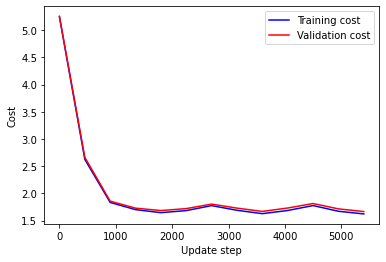

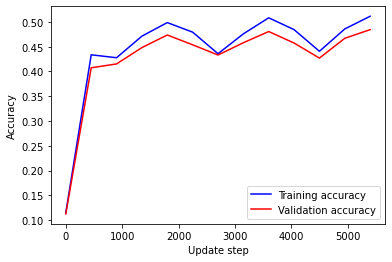

Final Accuracy on val set:  0.4844


In [7]:
plot(metrics)
print("Final Accuracy on val set: ", metrics['acc_val_scores'][-1])

In [ ]:
###############################################################

# Test 2: 3-layered network

###############################################################
hidden_layers = [50, 50]
W,b=GetWeightAndBias(X_new_norm, Y_new, 2, hidden_layers)
lambd= 0.005
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=2 
alpha=0.9
k=2

GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W_upd, b_upd, metrics= MiniBatchGD2(X_new_norm, Y_new, y_new,
                                         GDparams, W, b, 2, lambd, X_val_new_norm, 
                                         Y_val_new, y_val_new)

In [ ]:
plot(metrics)
print("Final Accuracy on val set: ", metrics['acc_val_scores'][-1])

In [7]:
###############################################################

# Test 3: 9-layered network

###############################################################
hidden_layers = [50, 30, 20, 20, 10, 10, 10, 10]
W,b=GetWeightAndBias(X_new_norm, Y_new, 8, hidden_layers)
lambd= 0.005
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=2 

GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W_upd, b_upd, metrics= MiniBatchGD2(X_new_norm, Y_new, y_new,
                                         GDparams, W, b, 8, lambd, X_val_new_norm, 
                                         Y_val_new, y_val_new)

3072
50
30
20
20
10
10
10


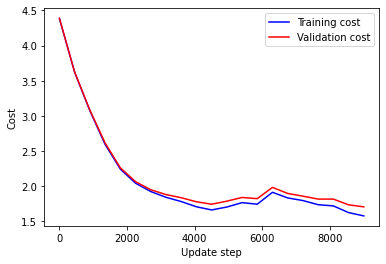

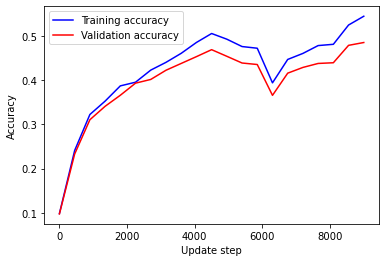

Final Accuracy on val set:  0.4854


In [9]:
plot(metrics)
print("Final Accuracy on val set: ", metrics['acc_val_scores'][-1])

In [50]:
###############################################################

# Test 4: Testing batch norm implementation

###############################################################

# Read data
X_train, Y_train, y_test = ReadData('data_batch_1')
X_val_train, Y_val_train, y_val_test = ReadData('data_batch_2')
X_test_train, Y_test_train, y_test_test = ReadData('test_batch')

# Normalize all data w.r.t. mean and std of training data
X_train_normalized, X_val_train_normalized, X_test_train_normalized = Normalize(X_train, X_val_train, X_test_train)

# Create model params W and b
hidden_layers = [50, 50, 50, 50]
W, b, gamma, beta = GetWeightAndBias(X_train_normalized, Y_train, 4, hidden_layers, batch_norm=True)

# Model evaluation (softmax)
P, S_batch_Norm, S, H, mean, var = EvaluateClassifier(X_train_normalized, W, b, 4, gamma, beta, mean=None, var=None, batch_norm=True)

# Cost function
lambd = 0.0
A = ComputeCost(X_train_normalized, Y_train, W, b, lambd, 4, gamma, beta, mean=None, var=None, batch_norm=False)
print("Cost: ", A)
# Accuracy
A = ComputeAccuracy(X_train_normalized, y_test, W, b, 4, gamma, beta, mean=None, var=None, batch_norm=True)
print("Accuracy: ", A,"\n")


# Compute gradients
lambd = 0
grad_W,grad_b,grad_gamma,grad_beta = ComputeGradients(H, X_train_normalized, Y_train,P,W, b, lambd, 4, gamma, beta, mean, var, S_batch_Norm, S, True)

# Compare numerical gradients with analytical
threshold = 1e-5
W_sub = [sub_W[:, 0:20] for sub_W in W]
h_sub = [sub_H[0:20, :] for sub_H in act_vals]
b_sub = [sub_b[:, 0:20] for sub_b in b]


W_cut = list()

count = 1
for w in W:
    if count == 1:
        W_cut.append(w[:, 0:10])
    else:
        W_cut.append(w)
    count += 1
    
CompareGradients(X_train_normalized[0:10, [0]],Y_train[:, [0]],
                     W_cut, b, lambd, 4, threshold,gamma, beta, batch_norm=True)

Cost:  2.7928912963590373
Accuracy:  0.1032 

<class 'numpy.float64'> c
Checking errors for  4 layers 

--------------------------------------------
Relative error for layer:  [1]  is ok.
Weights relative error:  0.0
Bias relative error:  0.0 

Relative error for layer:  [2]  is ok.
Weights relative error:  0.0
Bias relative error:  0.0 

Relative error for layer:  [3]  is ok.
Weights relative error:  0.0
Bias relative error:  0.0 

Relative error for layer:  [4]  is ok.
Weights relative error:  0.0
Bias relative error:  0.0 

Relative error for layer:  [5]  is ok.
Weights relative error:  1.0538458605756471e-07
Bias relative error:  1.0535151607145269e-07 

--------------------------------------------
gamma0 100.0% of absolute errors below 1e-6
beta0 100.0% of absolute errors below 1e-6
gamma0 100.0% of relative errors below 1e-6
beta0 100.0% of relative errors below 1e-6
gamma1 100.0% of absolute errors below 1e-6
beta1 100.0% of absolute errors below 1e-6
gamma1 100.0% of relative e

In [29]:
###############################################################

# Test 5: Testing batch norm training with 2 hidden layers

###############################################################

hidden_layers = [50, 50]
W, b, gamma, beta = GetWeightAndBias(X_new_norm, Y_train, 2, hidden_layers, True)
P, S_batch_Norm, S, H, mean_inp, var_inp = EvaluateClassifier(X_new_norm, W, b, 2, gamma, beta, batch_norm=True)

lambd= 0.005
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=2 
alpha=0.9
k=2
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)

W_fin, b_fin, metrics = MiniBatchGD2_BN(X_new_norm, Y_new, y_new,
                                       GDparams, W, b, k, lambd,
                                        beta, gamma, mean_inp, var_inp, True, alpha,
                                       X_val_new_norm, Y_val_new, y_val_new)

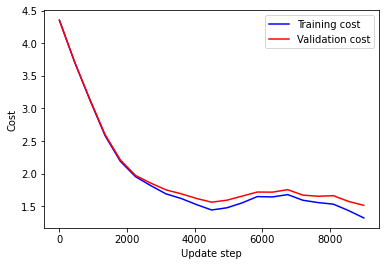

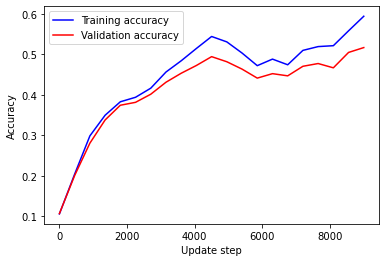

Final Accuracy on val set:  0.5166


In [28]:
plot(metrics)
print("Final Accuracy on val set: ", metrics['acc_val_scores'][-1])

[-2.80474598 -2.13924253 -2.5889465  -2.82046727 -3.3053808  -2.41642355
 -3.24965115]
[0.0004950159553733192, 0.0005627932047415164, 0.0015119336467640998, 0.0015676677195506057, 0.002576638574613588, 0.0038333321561566606, 0.007257005721594274]


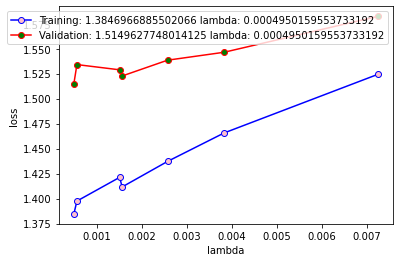

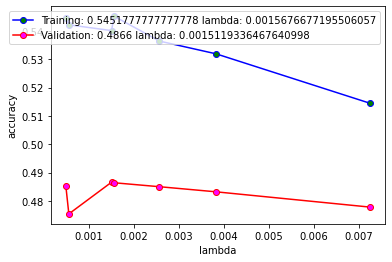

In [8]:
###############################################################

# Test 6: coarse and fine search of an optimal lambda value

###############################################################

def gridsearchCV(lambds, hidden_dimension, X, Y, y, GDparams, X_val=None,
                Y_val=None, y_val=None):
    metrics_grid = {'Loss_scores':[], 'acc_scores':[]}
    
    # Include validation data if there is some
    if X_val is not None:
        metrics_grid['Loss_val_scores'] = []
        metrics_grid['acc_val_scores'] = []
    
    for lambd in lambds:
        
        # Re-init weights for each lambda value
        W, b, gamma, beta = GetWeightAndBias(X_new_norm, Y_train, 2, hidden_layers, True)
        P, S_batch_Norm, S, H, mean_inp, var_inp = EvaluateClassifier(X_new_norm, W, b, 2, gamma, beta, batch_norm=True)
        
        # Build model with current lambda value 
        W, b, metrics, gamma, beta, mean_final, var_final = MiniBatchGD2_BN(X, Y, y, GDparams, W, b, 2, lambd, beta, gamma, mean_inp, var_inp, True, 0.9,X_val,Y_val,y_val)
        
        
        # Append to the metrics
        metrics_grid['Loss_scores'].append(metrics['Loss_scores'][-1])
        metrics_grid['acc_scores'].append(metrics['acc_scores'][-1])
        
        # Include validation data if there is some
        if X_val is not None:
            metrics_grid['Loss_val_scores'].append(metrics['Loss_val_scores'][-1])
            metrics_grid['acc_val_scores'].append(metrics['acc_val_scores'][-1])
    return metrics_grid

# Random lambda values
np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(7)
print(l)
lambds = list(10**l)
lambds.sort()
print(lambds)

# New params
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=2 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)

# Run test with random lambdas
metrics_grid=gridsearchCV(lambds, hidden_layers, X_new_norm, Y_new, y_new, GDparams, X_val_new_norm,
                Y_val_new, y_val_new)


# Plot of the random search
plot_metrics_grid(metrics_grid, lambds)

[0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.005, 0.01]


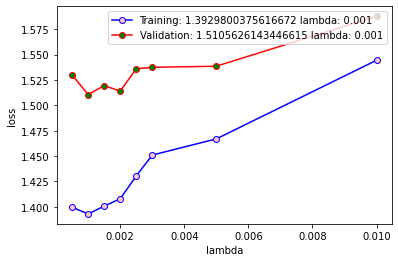

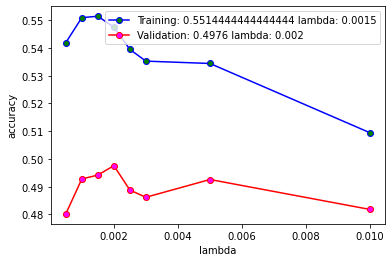

In [10]:
lambdas_list=[0.0005,0.001,0.0015,0.002,0.0025,0.003,0.005, 0.01]
print(lambdas_list)

# Run test with best lambdas 
metrics_grid=gridsearchCV(lambdas_list, hidden_layers, X_new_norm, Y_new, y_new, GDparams, X_val_new_norm,
                Y_val_new, y_val_new)

# Plot of the fine search
plot_metrics_grid(metrics_grid,lambdas_list)

In [15]:
###############################################################

# Test 7: Testing batch norm training with 3 layers and
# optimal lambda

###############################################################

hidden_layers = [50, 50]
W, b, gamma, beta = GetWeightAndBiasProper(X_new_norm, 2, hidden_layers, True)
P, S_batch_Norm, S, H, mean_inp, var_inp = EvaluateClassifier(X_new_norm, W, b, 2, gamma, beta, batch_norm=True)

lambd= 0.002
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=3 
alpha=0.9
k=2
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)

W, b, metrics, gamma, beta, mean_final, var_final = MiniBatchGD2_BN(X_new_norm, Y_new, y_new,
                                       GDparams, W, b, k, lambd,
                                        beta, gamma, mean_inp, var_inp, True, alpha,
                                       X_val_new_norm, Y_val_new, y_val_new)
plot(metrics)

In [23]:
plot(metrics)
print("Final Accuracy on test set: ", metrics['acc_val_scores'][-1])

Final Accuracy on test set:  0.5284



3072
50
30
20
20
10
10
10
----------------
3072
50
30
20
20
10
10
10
10


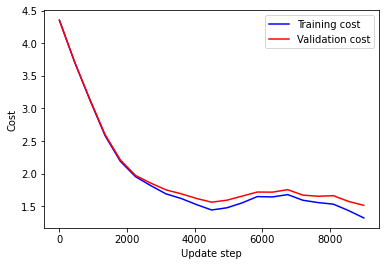

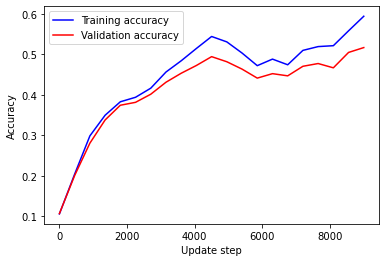

In [10]:
###############################################################

# Test 8: Testing batch norm training with 2 hidden layers and
# optimal lambda

###############################################################

hidden_layers = [50, 30, 20, 20, 10, 10, 10, 10] 
W, b, gamma, beta = GetWeightAndBias(X_new_norm, Y_new, 8, hidden_layers, True)
W, b, gamma, beta = GetWeightAndBiasProper(X_new_norm, 8, hidden_layers, True)
P, S_batch_Norm, S, H, mean_inp, var_inp = EvaluateClassifier(X_new_norm, W, b, 8, gamma, beta, batch_norm=True)

lambd= 0.005
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=2 
alpha=0.9
k=8
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)

W, b, metrics, gamma, beta, mean_final, var_final = MiniBatchGD2_BN(X_new_norm, Y_new, y_new,
                                       GDparams, W, b, k, lambd,
                                        beta, gamma, mean_inp, var_inp, True, alpha,
                                       X_val_new_norm, Y_val_new, y_val_new)

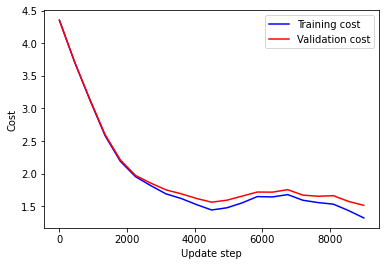

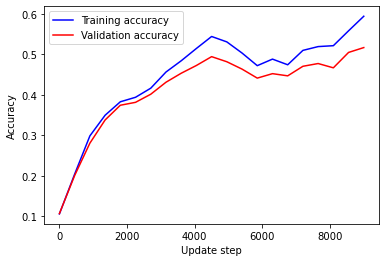

In [11]:
plot(metrics)

In [12]:
print("Final Accuracy on val set: ", metrics['acc_val_scores'][-1])

Final Accuracy on val set:  0.5166


In [15]:
###############################################################

# Test 9: Testing batch norm vs no batch norm weight init sensitivity  
# on the test set

###############################################################

hidden_dimension= [50, 50]
eta_min=1e-5
eta_max=1e-1
step_size=int((5*45000)/100)
n_batch=100
cycles=2 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)

SigmaExperiments(X_new_norm, Y_new, y_new, hidden_dimension, GDparams, 
                 X_val_new_norm, Y_val_new, y_val_new, X_test,Y_test,y_test)

<ipython-input-14-282388200be7>:206: RuntimeWarning: invalid value encountered in log
  lcr = -np.sum(np.multiply(Y, np.log(P)))
<ipython-input-12-854ccfed5786>:17: RuntimeWarning: overflow encountered in exp
  exp_x = np.exp(x)
<ipython-input-14-282388200be7>:206: RuntimeWarning: divide by zero encountered in log
  lcr = -np.sum(np.multiply(Y, np.log(P)))
<ipython-input-14-282388200be7>:206: RuntimeWarning: invalid value encountered in multiply
  lcr = -np.sum(np.multiply(Y, np.log(P)))


Sigma: 0.1, accuracy: 0.1. With batch norm.


<ipython-input-12-854ccfed5786>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.sum(exp_x, axis=0)
<ipython-input-14-282388200be7>:258: RuntimeWarning: invalid value encountered in greater
  G = G*(H[k]>0)
<ipython-input-14-282388200be7>:271: RuntimeWarning: invalid value encountered in greater
  G = G*(H[l]>0)


KeyboardInterrupt: 